In [1]:
!pip install einops
!pip install sk-video
!pip install pandas --upgrade
# !pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import collections
from torch.utils import data

import sys
sys.path.append('.')
sys.path.append('../')

from einops import rearrange

import torch
import torch.nn as nn
from torch.nn import functional as FeatureAlphaDropout
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from scipy import io as scipyio
import skimage
import skvideo.io
from utils import print_full

import os
import glob
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

In [3]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [4]:
from utils import set_seed
set_seed(25)

In [5]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

train_path = "stimulus"
video_stack = [skimage.io.imread(vid) for vid in glob.glob(train_path + '/*.tif')][::-1]
print(glob.glob(train_path + '/*.tif')[::-1])
video_stack = np.concatenate(video_stack, axis=0, dtype=np.float32)

# video_stack = skimage.io.imread("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif")
# video_stack = image_dataset(video_stack)
# video_stack = video_stack[::3]  # convert from 60 to 20 fps
# video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])
# video_stack = video_stack.transpose(-1, -2)

# rearrange(video_stack[0, 0:2].transpose(0,1), 'c t (h p1) (w p2) -> (t h w) (p1 p2 c)', p1=16, p2=16).shape

['stimulus/Combined Stimuli 3-Movie3.tif', 'stimulus/Combined Stimuli 3-grating.tif', 'stimulus/Combined Stimuli 3-Movie2.tif']
im_sack size: torch.Size([5760, 1, 64, 112])


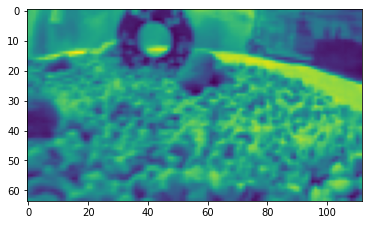

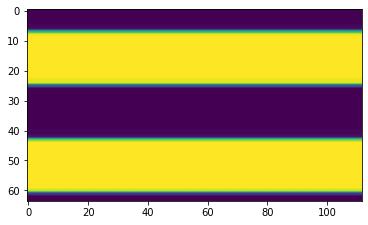

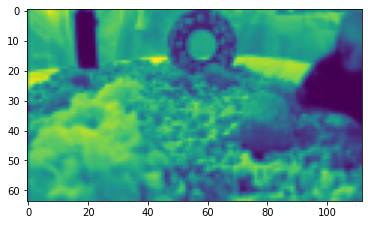

In [6]:
plt.figure()
plt.imshow(video_stack[0, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[1, 1].permute(1, 2, 0))
plt.figure()
plt.imshow(video_stack[2, 1].permute(1, 2, 0))

In [7]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat("spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [8]:
# df = df[df['Trial'] > 20]

In [9]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.01

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['Interval_dt'] = make_intervals(df, dt)
df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(2)
df = df.reset_index(drop=True)

In [10]:
n_dt = sorted((df['Interval_dt'].unique()).round(3)) # add last interval for EOS'

df['Time'] = df['Time'].round(3)

In [11]:
# df.groupby(['Interval', 'Trial']).size().plot.bar()
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
df.groupby(['Interval', 'Trial']).size().nlargest(100)

Interval  Trial
18.5      42       49
4.5       45       36
26.0      49       35
29.0      26       35
4.0       23       33
                   ..
          29       21
          33       21
4.5       22       21
7.0       13       21
7.5       7        21
Length: 100, dtype: int64

In [12]:
df

,Time,ID,Trial,Interval,Interval_dt
0,0.031,16,1,0.5,0.04
1,0.055,156,1,0.5,0.06
2,0.143,105,1,0.5,0.15
3,0.161,109,1,0.5,0.17
4,0.198,72,1,0.5,0.20
...,...,...,...,...,...
25607,31.697,156,60,32.0,0.20
25608,31.749,80,60,32.0,0.25
25609,31.802,141,60,32.0,0.31
25610,31.842,152,60,32.0,0.35


In [13]:
from SpikeVidUtils import SpikeTimeVidData

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
frame_feats = video_stack.transpose(1, 2)

frame_block_size = 560
prev_id_block_size = 30
id_block_size = 30 * 2    # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
# pixels = sorted(np.unique(frames).tolist())
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.5

In [14]:
df

,Time,ID,Trial,Interval,Interval_dt
0,0.031,16,1,0.5,0.04
1,0.055,156,1,0.5,0.06
2,0.143,105,1,0.5,0.15
3,0.161,109,1,0.5,0.17
4,0.198,72,1,0.5,0.20
...,...,...,...,...,...
25607,31.697,156,60,32.0,0.20
25608,31.749,80,60,32.0,0.25
25609,31.802,141,60,32.0,0.31
25610,31.842,152,60,32.0,0.35


In [15]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
for n_stim in range(3):
    n_trial = [15, 5]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [16]:
n

[5, 15, 25, 35, 45, 55]

In [17]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)


print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

Length: 23138 Neurons: 168 Pixels: 0.
id block size: 60
frames: 560, id: 60
Length: 2474 Neurons: 168 Pixels: 0.
id block size: 60
frames: 560, id: 60
Length: 393 Neurons: 168 Pixels: 0.
id block size: 60
frames: 560, id: 60
train: 3312, test: 358


In [18]:
# def get_class_weights(df, population_size):
#     class_freq = df.groupby(['ID']).size().nlargest(2)
#     class_freq_pad = np.arra0y(class_freq.tolist() + [class_freq.max()]*(population_size - len(class_freq)), dtype=np.float32)
#     return torch.tensor(np.reciprocal(class_freq_pad) * class_freq.max(), dtype=torch.float32) / class_freq.max()

def get_class_weights(df, population_size):
    len_data = len(train_data.drop_duplicates(subset=['Interval', 'Trial'])[['Interval', 'Trial']])
    id_freq = [len(df[df['ID'] == id]) for id in range(neurons[-1] + 1)]
    sos_freq = [len_data * 2]
    eos_freq = [len_data * 1]
    pad_freq = [(len_data * (id_block_size + prev_id_block_size)) - len(df)]
    class_freq = np.array(id_freq + sos_freq + eos_freq + pad_freq, dtype=np.float32)
    class_freq = torch.tensor(np.reciprocal(class_freq) * class_freq.max(), dtype=torch.float32) / class_freq.max()
    return torch.nan_to_num(class_freq, 1)

class_weights = get_class_weights(df, train_dataset.id_population_size)

<ipython-input-18-1a52f6ab5400>:13: RuntimeWarning: divide by zero encountered in reciprocal
  class_freq = torch.tensor(np.reciprocal(class_freq) * class_freq.max(), dtype=torch.float32) / class_freq.max()


In [19]:
video_stack.shape

torch.Size([3, 640, 1, 64, 112])

In [20]:
# def get_class_weights(df, population_size):
#     class_freq = df.groupby(['ID']).size().nlargest(2)
#     class_freq_pad = np.array(class_freq.tolist() + [class_freq.max()]*(population_size - len(class_freq)), dtype=np.float32)
#     return torch.tensor(np.reciprocal(class_freq_pad) * class_freq.max(), dtype=torch.float32) / class_freq.max()

def get_class_weights(df, population_size):
    len_data = len(train_data.drop_duplicates(subset=['Interval', 'Trial'])[['Interval', 'Trial']])
    id_freq = [len(df[df['ID'] == id]) for id in range(neurons[-1] + 1)]
    sos_freq = [len_data * 2]
    eos_freq = [len_data * 1]
    pad_freq = [(len_data * (id_block_size + prev_id_block_size)) - len(df)]
    class_freq = np.array(id_freq + sos_freq + eos_freq + pad_freq, dtype=np.float32)
    class_freq = torch.tensor(np.reciprocal(class_freq) * class_freq.max(), dtype=torch.float32) / class_freq.max()
    return torch.nan_to_num(class_freq, 1)

class_weights = get_class_weights(df, train_dataset.id_population_size)

<ipython-input-20-81aea9b96df6>:13: RuntimeWarning: divide by zero encountered in reciprocal
  class_freq = torch.tensor(np.reciprocal(class_freq) * class_freq.max(), dtype=torch.float32) / class_freq.max()


In [21]:
# class_weights.max()

In [22]:
from model_perceiver import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=class_weights,
                        pretrain=True,
                        n_layer=8, n_head=8, n_embd=256,
                        temp_emb=True, pos_emb=True,
                        id_drop=0.2, im_drop=0.2)
model = GPT(mconf)
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-08-21-00:35-e:211-b:272-l:5-h:2-ne:512-higher_order.pt"))

01/03/2022 17:26:12 - INFO - model_perceiver -   number of parameters: 6.614528e+06


In [ ]:
from trainer import Trainer, TrainerConfig
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-01-21-14:18-e:19-b:239-l:4-h:2-ne:512-higher_order.pt"))
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-14-21-23:44-e:17-b:650-l:8-h:4-ne:256-higher_order.pt"))

max_epochs = 400
batch_size = 64
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                      num_workers=4, lr_decay=True, warmup_tokens=2e5, 
                      decay_weights=True,
                      final_tokens=len(train_dataset)*(block_size // 8) * (max_epochs),
                      clip_norm=3.0, grad_norm_clip=2.0,
                      dataset='higher_order', mode='predict',
                      block_size=train_dataset.block_size,
                      id_block_size=train_dataset.id_block_size,
                      show_grads=False, plot_raster=False,
                      pretrain_ims=False, pretrain_ids=False)

trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
trainer.train()  

epoch 1  id_train: 5.15563  total_loss: 5.07090 lr 9.792000e-05: 100%|██████████| 52/52 [00:24<00:00,  2.11it/s]
01/03/2022 17:26:38 - INFO - trainer -   id_test: 5.26803  total_loss: 5.26803
01/03/2022 17:26:38 - INFO - trainer -   saving None
epoch 2  id_train: 5.09901  total_loss: 5.00351 lr 9.936000e-05: 100%|██████████| 52/52 [00:24<00:00,  2.14it/s]
01/03/2022 17:27:03 - INFO - trainer -   id_test: 5.27357  total_loss: 5.27357
01/03/2022 17:27:03 - INFO - trainer -   saving None
epoch 3  id_train: 5.01768  total_loss: 5.02430 lr 9.936000e-05:  77%|███████▋  | 40/52 [00:18<00:05,  2.15it/s]

In [ ]:
# model.load_state_dict(torch.load(parent_path + "code/transformer_vid3/model_cnn_78.pt"))
# torch.save(model.state_dict(), 'epoch_382_model.pt')

In [ ]:
""" Predict using TEST dataset """

from utils import predict_raster, predict_raster_resnet, predict_raster_enc_dec, predict_raster_recursive, predict_beam_search, predict_raster_recursive_time, predict_beam_search_time, predict_raster_hungarian
%matplotlib inline

loader = DataLoader(test_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)

# device = torch.cuda.current_device()
# model = model.to(device)
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-14-21-11:49-e:1-b:650-l:4-h:4-ne:256-higher_order.pt"))

""" 

To predict only neurons we pass <frame_end> so we see predictions only for Neurons 
If you want to also see frame_tokens, just pass <frame_end=0>

NOTE: 512 ID is the <end-of-sequence-id>. Right now, makes no difference if I include
it in loss, here it is included in loss and predictions.

"""
# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted = predict_raster(model, loader)

# true, predicted = predict_beam_search(model, loader, stoi, frame_end=frame_block_size)
true, predicted, true_timing = predict_raster_recursive(model, loader, stoi, sample=True, top_k=15, gpu=True, frame_end=frame_block_size)
# true, predicted = predict_raster_hungarian(model, loader)
# true, predicted = predict_raster(model, loader, gpu=True)

true_df = pd.DataFrame(true.numpy())
predicted_df = pd.DataFrame(predicted.numpy())
print(len(true_df[true_df[0] == 512]), len(predicted_df[predicted_df[0] == 512])) 

In [ ]:
# model.load_state_dict(torch.load(parent_path + "code/transformer_vid3/runs/models/12-10-21-18:16-e:18-b:635-l:3-h:4-ne:256-higher_order.pt"))
torch.save(model.state_dict(), 'epoch_400_modelGPT.pt')

In [ ]:
test_data['Time']

In [ ]:
# loader = DataLoader(train_dataset, shuffle=False, pin_memory=False,
#                                   batch_size=1, num_workers=1)

# true_train, predicted_train, true_timing_train = predict_raster_recursive(model, loader, stoi, sample=None, top_k=None)

In [ ]:
true_df = pd.DataFrame(true.numpy())
predicted_df = pd.DataFrame(predicted.numpy())
print(len(true_df[true_df[0] >= 512]), len(predicted_df[predicted_df[0] >= 512])) 

In [ ]:
true

In [ ]:
def plot_this(true_df, predicted_df):
    plt.figure(figsize=(30,20))
    n_min = 165
    freq_true = true_df[true_df[0] < n_min].groupby([0]).size()
    print(freq_true)
    freq_pred = predicted_df[predicted_df[0] < n_min].groupby([0]).size()
    plt.bar(freq_pred.index, freq_pred, label='predicted', alpha=0.5)
    plt.bar(freq_true.index, freq_true, label='true', alpha=0.5)
    plt.title('Neuron Firing Distribution (PSTH Loss)', fontsize=40)
    plt.legend(fontsize=30)
    plt.show()

plot_this(pd.DataFrame(true.numpy()), pd.DataFrame(predicted.numpy()))

In [ ]:
df['Trial'][df['Trial'] == 10]

In [ ]:
def plot_this(true_df, predicted_df):
    plt.figure(figsize=(30,20))
    n_min = 512
    freq_true = true_df.groupby(['ID']).size()
    freq_pred = predicted_df.groupby(['ID']).size()
    plt.bar(freq_pred.index, freq_pred, label='Trial 5', alpha=0.5)
    plt.bar(freq_true.index, freq_true, label='Trial 10', alpha=0.5)
    plt.title('Neuron Firing Distribution (PSTH Loss)', fontsize=40)
    plt.legend(fontsize=30)
    plt.show()

plot_this(df[df['Trial'] == 5], df[df['Trial'] == 10])

In [ ]:
len(true)

In [ ]:
len_pred = len(true)
# len_pred = 1000
plt.figure(figsize=(40,40))
plt.title('Pixel / Spike Raster', size=50)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.scatter(np.arange(len_pred), true[:len_pred], alpha=0.6, label='true', marker='o')
plt.scatter(np.arange(len_pred), predicted[:len_pred], alpha=0.6, label='predicted', marker='x')
plt.legend(fontsize=50)

In [ ]:
true_df = pd.DataFrame(true.numpy())
predicted_df = pd.DataFrame(predicted.numpy())
print(len(true_df[true_df[0] == 512]), len(predicted_df[predicted_df[0] == 512])) 

plt.figure(figsize=(30,20))
n_min = 10000
freq_true = df[(df['ID'] < n_min) & (df['Trial'] == 4)].groupby(['ID']).size()
freq_pred = predicted_df[predicted_df[0] < n_min].groupby([0]).size()
plt.bar(freq_true.index, freq_true, label='true', alpha=0.3)
# plt.bar(freq_pred.index, freq_pred, label='predicted', alpha=0.3)
plt.title('Neuron Firing Distribution (PSTH Loss)', fontsize=40)
plt.legend(fontsize=30)
plt.show()

In [ ]:
df = pd.DataFrame({'True':true, 'Predicted':predicted, 
                   })

# df_pred = pd.DataFrame({'True':true, 'Predicted':predicted, 'Time':true_timing / 100})

df.to_csv('GPT-one_combo_73-train.csv', index=False)

# df_pred = pd.read_csv(parent_path + "/transformer_vid3/analysis/cs-k25_2-simNeu_3D_WithNorm__Combo3-train.csv")
# df_pred = df_pred.iloc[:, 1:]

In [ ]:
df

In [ ]:
block_size

In [ ]:
146 + 22

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
train_dataset.id_block_size + train_dataset.id_prev_block_size

In [ ]:
frame_block_size

In [ ]:
train_dataset.id_prev_block_size

In [ ]:
loader = DataLoader(test_dataset, shuffle=True, pin_memory=False,
                                  batch_size=2, num_workers=1)

In [ ]:
iterable = iter(loader)

In [ ]:
frame_feats.shape

In [ ]:
x, y = next(iterable)

In [ ]:
x['frames'].shape

In [ ]:
x['dt_prev']

In [ ]:
# df[(df['Interval'] == x['interval'][0]) & (df['Trial'] == x['interval'][1])])

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for key, value in x.items():
    x[key] = x[key].to(device)
for key, value in y.items():
    y[key] = y[key].to(device)

In [ ]:
# model = model.cuda()
model = model.cpu()
model(x, y)

In [ ]:
y['dt'].shape

In [ ]:
x['id'].shape

In [ ]:
x['dt'].shape

In [ ]:
x['id'][:, :x['id'].shape[-1] - x['pad']]

In [ ]:
y['id'][:, :x['id'].shape[-1] - x['pad']]

In [ ]:
x['interval']

In [ ]:
plt.imshow(x['frames'][0, :, -1].permute(1, 2, 0), cmap='gray')

In [ ]:
x['interval'][0]

In [ ]:
df[(df['Interval'] >= (x['interval'][0] - 1)) & (df['Interval'] <= x['interval'][0]) & (df['Trial'] == x['interval'][1])]

In [ ]:
x['id_prev']

In [ ]:
x['dt']

In [ ]:
x['dt_prev']

In [ ]:
x['id']

In [ ]:
id_s = id_block_size + prev_id_block_size

In [ ]:
y['id'][:, :id_s - x['pad'] + 1]

In [ ]:
math.ceil((20 + 21) // 20 - 1)

In [ ]:
model.to('cpu')

In [ ]:
x.keys()

In [ ]:
preds, features, loss = model(x)

In [ ]:
preds['logits'][:, frame_block_size: frame_block_size + x["pad_prev"]].shape

In [ ]:
x['dt'].shape

In [ ]:
x['id'].shape

In [ ]:
y['id'].shape

In [ ]:
y['dt'].shape

In [ ]:
x['id'].shape

In [ ]:
stoi_dt

In [ ]:
x['dt']

In [ ]:
y['dt']

In [ ]:
xx = x['dt'].flatten().tolist()

In [ ]:
ss = [xx[n + 1] - xx[n] for n in range(len(xx) - 1)]

In [ ]:
ss

In [ ]:
x['dt'].shape

In [ ]:
frame_block_size + id_block_size + prev_id_block_size

In [ ]:
model(x, y)

In [ ]:
x['interval'] = x['interval'].flatten().tolist()

In [ ]:
interval = x['interval'][0]
trial = x['interval'][1]
prev_int = interval - 1
prev_int = prev_int if prev_int > 0 else 0  
prev_id_interval = prev_int, interval
data_prev = df[(df['Interval'] >= prev_id_interval[0]) & 
                        (df['Interval'] < prev_id_interval[1]) &
                        (df['Trial'] == trial)]

In [ ]:
df.index[(df['Interval'] == x['interval'][0]) & (df['Trial'] == x['interval'][1])]

In [ ]:
idx = df.index[(df['Interval'] == x['interval'][0]) & (df['Trial'] == x['interval'][1])].item()
df[(df['Interval'] == x['interval'][0]) & (df['Trial'] == x['interval'][1])]

In [ ]:
print(x['interval'])

In [ ]:
x['id'], x['id_prev']

In [ ]:
df.iloc[idx - 10:idx + 2]

In [ ]:
x['frames'].shape

In [ ]:
frame.shape

In [ ]:
frame = x['frames'][0, :, 10]
frame = frame.transpose(0, -1)
plt.imshow(frame, cmap='gray')

In [ ]:
df[df['Interval'] == 0.2]

In [ ]:
x['dt_prev']

In [ ]:
x['dt']

In [ ]:
from model_perceiver import VideoFeaturesExtractor

vid = VideoFeaturesExtractor()
vid(x['frames']).shape

In [ ]:
class_weights

In [ ]:
for key, value in x.items():
    x[key] = x[key].cuda()
for key, value in y.items():
    y[key] = y[key].cuda()

In [ ]:
x['id'].shape

In [ ]:
x['frames'].shape

In [ ]:
x['id'].shape

In [ ]:
x['id'][:, :t - x['pad']]

In [ ]:
y['id'][:, :t - x['pad']]

In [ ]:
y

In [ ]:
# model = model.to('cpu')
model = model.cuda()
preds, features, loss = model(x, y)

In [ ]:
loss

In [ ]:
preds['logits']

In [ ]:
loss

In [ ]:
y['id']

In [ ]:
preds['logits'].shape

In [ ]:
t = x['id'].shape[-1]

In [ ]:
pad = x['pad']

In [ ]:
for i in range(t - pad):
    print(i)

In [ ]:
x = {'id' : 2}
def yes(x):
    print(x['id'])
    x['id'] -= 1
    return x

In [ ]:
yes(x)

In [ ]:
x['id']

In [ ]:
y['id']

In [ ]:
x['id'].shape

In [ ]:
x['id'][:, 0]

In [ ]:
x['id'][:, :21 - x['pad']]
y['id'][:, :21 - x['pad']]

In [ ]:
y['id']

In [ ]:
x['pad']

In [ ]:
x['id'].shape

In [ ]:
x['id'][:, 0].shape

In [ ]:
y['id']

In [ ]:
t = x['id'].shape[-1]

In [ ]:
t

In [ ]:
t - x['pad']

In [ ]:
tt = torch.tensor([512])

torch.cat((x['id'], tt[None, ...]), dim=-1)

In [ ]:
model = model.to('cpu')
preds, features, loss = model(x, y)

In [ ]:
preds['logits'][0].shape

In [ ]:
from utils import predict_raster, predict_time_raster, predict_raster_enc_dec
%matplotlib inline
from utils import set_plot_params
set_plot_params()
# model.load_state_dict(torch.load(parent_path + "code/transformer_vid3/runs/models/10-20-21-18:40-e:9-b:166-l:4-h:4-ne:512-higher_order.pt"))
loader = DataLoader(test_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=4)
# device = torch.cuda.current_device()
# model = model.to(device)

# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, frame_block_size, train_dataset.id_block_size)
true, predicted, timing = predict_raster_enc_dec(model, loader, frame_block_size, get_dt=True)

true_df = pd.DataFrame(true.numpy())
predicted_df = pd.DataFrame(predicted.numpy())
print(len(true_df[true_df[0] < 512]), len(predicted_df[predicted_df[0] < 512])) 

In [ ]:
from utils import set_plot_params
set_plot_params()

plt.rcParams['xtick.labelsize'] = 45
plt.rcParams['ytick.labelsize'] = 45
plt.rcParams['axes.labelsize'] = 45
plt.rcParams['figure.titlesize'] = 1000
plt.rcParams['axes.labelpad'] = 17

len_pred = len(true) # len(true)
plt.figure(figsize=(40,40))
plt.title('Pixel / Spike Raster', size=50)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.scatter(np.arange(len_pred), true, alpha=0.6, label='true', marker='o') # true[len_pred:2 * len_pred], alpha=0.6, label='true', marker='o')
plt.scatter(np.arange(len_pred), predicted, alpha=0.6, label='predicted', marker='x') # predicted[len_pred: 2 * len_pred], alpha=0.6, label='predicted', marker='x')
plt.legend()

In [ ]:
get_id = lambda data, id_: np.where(data <= 512, data, None)

idn = 174
id_true = get_id(true, idn)
id_predicted = get_id(predicted, idn)
len_pred = len(true)
plt.figure(figsize=(20,20))
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.title(f'Neuron ID {idn}', size=20)
plt.xlabel('Time', size=20)
plt.ylabel('Response', size=20)
plt.scatter(np.arange(len(id_true[:len_pred])), id_true[:len_pred], alpha=0.7, label='true', s=75)
plt.scatter(np.arange(len(id_predicted[:len_pred])), id_predicted[:len_pred], alpha=0.6, label='predicted', marker='x', s=75)

In [ ]:
def build_time_seq(time_list):
    times = []
    current_time = 0
    for dt in time_list:
        if dt == 0:
            dt = current_time
        times.append(dt)
    return times

predicted_time = build_time_seq(predicted_timing)
true_time = build_time_seq(true_timing)

In [ ]:
from utils import set_plot_params
set_plot_params()

len_pred = 2000 # len(true)
plt.figure(figsize=(40,40))
plt.title('Pixel / Spike Raster', size=50)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.scatter(true_time[:len_pred], true[:len_pred], alpha=0.6, label='true', marker='o')
plt.scatter(predicted_time[:len_pred], predicted[:len_pred], alpha=0.6, label='predicted', marker='x')
plt.legend()

In [ ]:
from utils import set_plot_params
set_plot_params()

len_pred = 2000 # len(true)
plt.figure(figsize=(40,40))
plt.title('Pixel / Spike Raster', size=50)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.scatter(np.arange(len_pred), true_time[:len_pred], alpha=0.6, label='true', marker='o')
plt.scatter(np.arange(len_pred), predicted_time[:len_pred], alpha=0.6, label='predicted', marker='x')
plt.legend()

In [ ]:
loader = DataLoader(train_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)
iterable = iter(loader)

In [ ]:
import torch.nn.functional as F 

x, y = next(iterable)
T = train_dataset.id_block_size
frame_end = 0
logits, features, _ = model(x)
PAD = x['pad']
logits = logits[:, frame_end:T - PAD, :]    # get last unpadded token (-x['pad'])
# take logits of final step and apply softmax
probs = F.softmax(logits, dim=-1)
# choose highest topk (1) sample
_, ix = torch.topk(probs, k=1, dim=-1)

In [ ]:
decoder.generate_padding_mask(x['pad'])

In [ ]:
decoder = Decoder(mconf)
decoder(model.tok_emb(x['id']), x['frames'], x['pad'])

In [ ]:
logits

In [ ]:
x['pad']

In [ ]:
len(ix.flatten())

In [ ]:
ix.flatten()

In [ ]:
x['id']

In [ ]:
x['pad']

In [ ]:
y[:, frame_end:T - x['pad']].flatten()

In [ ]:
logits.shape

In [ ]:
# torch.save(model.state_dict(), 'model_under1.pt')

In [ ]:
get_id = lambda data, id_: np.where(data <= 512, data, None)

idn = 174
id_true = get_id(true, idn)
id_predicted = get_id(predicted, idn)
len_pred = len(true)
plt.figure(figsize=(20,20))
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.title(f'Neuron ID {idn}', size=20)
plt.xlabel('Time', size=20)
plt.ylabel('Response', size=20)
plt.scatter(np.arange(len(id_true[:len_pred])), id_true[:len_pred], alpha=0.4, label='true', s=75)
plt.scatter(np.arange(len(id_predicted[:len_pred])), id_predicted[:len_pred], alpha=0.4, label='predicted', marker='x', s=75)

In [ ]:
from SpikeVidUtils import SpikeTimeVidData

# train_dat1aset = spikeTim/eData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData(train_data, frames,  block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, frame_feats)
test_dataset = SpikeTimeVidData(test_data, frames, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, frame_feats)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], frames, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, frame_feats)


print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

In [ ]:
loader = DataLoader(train_dataset, shuffle=False, pin_memory=False,
                                  batch_size=2, num_workers=1)

In [ ]:
iterable = iter(loader)

In [ ]:
x, y = next(iterable)

In [ ]:
y.shape

In [ ]:
logits, features, _ = model(x)

In [ ]:
logits.shape

In [ ]:
model(x).shape

In [ ]:
x['frames']

In [ ]:
x['id'].shape

In [ ]:
y.shape

In [ ]:
xy = torch.rand(2, 100, 1)

In [ ]:
xy.squeeze(-1).shape

In [ ]:
model.to('cpu')
logits, features, loss = model(x, y)

In [ ]:
loss

In [ ]:
logits[1]

In [ ]:
x['pad']

In [ ]:
x['id'].shape

In [ ]:
x['frames'].shape

In [ ]:
block_size = 4

In [ ]:
mask = torch.tril(torch.ones((block_size, block_size))
                                     ).view(1, 1, block_size, block_size)

In [ ]:
mask

In [ ]:
mask[:, :, :, 3:] = 1

In [ ]:
mask

In [ ]:
model = model.to('cpu')

In [ ]:
x, y = model(x, y)

In [ ]:
# len(df[(df['Interval'] == 238.5) & (df['Trial'] == 0)])

In [ ]:
# interval_prev = 238.5 - window*5
# data_prev = df[(df['Interval'] > 3) & 
# (df['Interval'] < 6)]

In [ ]:
# data_prev

In [ ]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(10, 32, 512)
tgt = torch.rand(20, 32, 512)
out = transformer_decoder(tgt, memory)
